In [20]:
import pandas as pd
import numpy as np
import re
import emoji
import altair as alt
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import wordcloud
from gensim.models import Word2Vec
import gensim
from gensim.test.utils import common_texts, get_tmpfile
# from collections import defaultdict
# import nltk
# from nltk.data import find

# nltk.download("word2vec_sample")

In [10]:
df = pd.read_csv('./data/train.csv')
df.shape

(7613, 5)

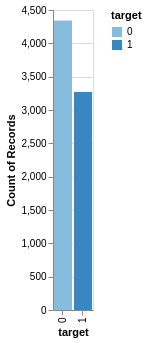

In [11]:
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(df).mark_bar().encode(
    alt.X("target:O", bin=False),
    y='count()', color = 'target:O'
)

### Unclean Word Could

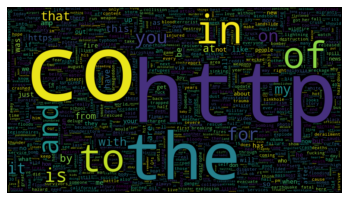

In [14]:
# freq of words in corpus
vectorizer = CountVectorizer()
cv = vectorizer.fit_transform(df.text)

word_list = vectorizer.get_feature_names();    
count_list = cv.toarray().sum(axis=0)  
counts_dict = dict(zip(word_list, count_list))
cloud = wordcloud.WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(counts_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Preprocess

In [15]:
#https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python => removes other special symbols too...
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [16]:
# Preprocess - Remove URLs, repeating characters (llooolll -> lol), lower, and deemojify, remove stopwords
stop_words = set(stopwords.words('english'))

for i in range(len(df.text)):
    df['text'].iloc[i] = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', "", df['text'].iloc[i])
    df['text'].iloc[i] = re.sub(r"([a-z]+?)\1{2,}", r"\1", df['text'].iloc[i].lower())
    df['text'].iloc[i] = deEmojify(df['text'].iloc[i])
    df['text'].iloc[i] = ' '.join([w.strip('#') for w in df.text[i].split() if not w in stop_words])
    

In [17]:
# freq of words in corpus
vectorizer = CountVectorizer()
cv = vectorizer.fit_transform(df.text)

word_list = vectorizer.get_feature_names();    
count_list = cv.toarray().sum(axis=0)  
counts_dict = dict(zip(word_list, count_list))
counts_dict['fire']

252

### Clean WordCloud!

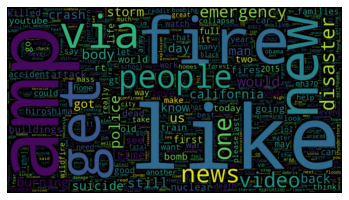

In [22]:
cloud = wordcloud.WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(counts_dict)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Try and clean mispellings...

In [ ]:
# This wont work, too slow
from spellchecker import SpellChecker
spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'eazy', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

## Training Round One: Using CountVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(6090,) (1523,)


In [ ]:
vectorizer = CountVectorizer(stop_words = 'english', min_df=2) # dont include stopwords
X = vectorizer.fit_transform(X_train)
X.shape # 6090 tweets, 5339 unique words

(6090, 5339)

In [ ]:
xtest = vectorizer.transform(X_test)

In [ ]:
# off the shelf SGD classifier
clf = SGDClassifier()
clf.fit(X, y_train)
clf.score(xtest, y_test)

0.7636244254760342

In [ ]:
# Pipeline to optimize - tried SGDClassifier and SVC, and Logistic Regression

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
    'clf__kernel': ('rbf', 'linear', 'sigmoid'),
    'clf__C': (0.001, 0.01, 0.1, 1, 10),
    'clf__class_weight':(None, 'balanced'),
#     'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (200, 500),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'clf__C': 10, 'clf__class_weight': None, 'clf__kernel': 'rbf', 'clf__max_iter': 500, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}
0.7251231527093597


/home/ilana/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
clf = SVC(kernel = 'rbf', C = .7, class_weight='balanced')
clf.fit(X, y_train)
clf.score(xtest, y_test)

0.8056467498358503

## Training Round Two - Mean PreTrained Twitter Glove Embeddings per tweet

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
#         self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.array([ 7.37443715e-02, -7.94042051e-02,  5.74398562e-02,  1.41756947e-03,
        7.09078535e-02, -8.97425972e-03, -3.66299525e-02, -5.79464473e-02,
       -5.99087104e-02,  6.46981690e-03, -8.34590942e-02, -7.87321776e-02,
        4.34277244e-02,  3.82820889e-02,  1.70872472e-02, -2.63196640e-02,
        6.98679611e-02, -6.87235147e-02,  6.56387061e-02, -5.85974753e-02,
        8.32159817e-02, -1.41953640e-02, -4.67632711e-02,  1.18665420e-01,
        1.49420062e-02, -4.57915775e-02, -8.56415927e-02,  1.97635926e-02,
        5.71056269e-02, -1.75720751e-02,  2.64543574e-02,  2.43167132e-02,
       -2.82315221e-02,  6.42109215e-02, -7.59002846e-03, -1.56401377e-02,
       -6.27836492e-03,  2.74267793e-02,  3.98579985e-02, -6.00792542e-02,
       -8.78325328e-02,  6.92038462e-02, -3.83613445e-02, -1.39193833e-02,
        3.28736641e-02, -7.94622954e-03,  5.17376214e-02,  2.31165010e-02,
       -6.51438162e-02, -5.56912869e-02,  1.42309582e-02,  7.29377344e-02,
       -8.12695846e-02,  1.68136172e-02,  2.33106427e-02,  1.84900016e-02,
        1.04072737e-02,  3.83687504e-02, -6.80672228e-02, -1.46726836e-02,
       -1.84725970e-02,  9.91673097e-02, -9.44764540e-02, -9.49441548e-03,
       -1.79902948e-02,  3.87691893e-02, -8.12552124e-02, -4.08506989e-02,
        1.74245238e-02,  1.16622321e-01, -1.45220710e-02, -4.79656011e-02,
       -5.89338802e-02, -5.82395114e-05,  3.48038785e-02,  4.24071513e-02,
       -7.22463354e-02, -8.44456032e-02,  9.43158194e-02, -2.74182167e-02,
        7.99887329e-02,  5.32620363e-02, -1.19918995e-02, -1.38135385e-02,
       -1.28890080e-02,  7.14779720e-02,  1.26950219e-02,  1.16986059e-01,
       -1.92024857e-02, -3.17104496e-02,  4.55324762e-02, -5.61099127e-02,
        9.92853567e-02,  1.24592029e-01, -3.73684950e-02, -7.68408924e-02,
       -2.58651581e-02,  1.96013204e-03,  2.03586854e-02,  4.69751544e-02])], axis=0)
            for words in X
        ])
    
with open("./embeddings/glove.twitter.27B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}
    
model = gensim.models.Word2Vec([tweet.split() for tweet in df.text], size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [ ]:
X = [sent.split() for sent in df.text]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df.target, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

In [ ]:
emb = MeanEmbeddingVectorizer(w2v)
emb.fit(X_train, y_train)
X_train = emb.transform(X_train)

In [ ]:
# Pipeline to optimize - tried word embeddings
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
        ('scaler', StandardScaler()),
    ("clf", SVC())]) #RandomForestClassifier(n_estimators=200)
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', SVC()),
# ])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {

#     'clf__alpha': (0.00001, 0.000001),
    'clf__kernel': ('rbf', 'linear', 'sigmoid'),
    'clf__C': (0.01, 0.7, 0.1, 1, 10),
    'clf__class_weight':(None, 'balanced'),
#     'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (1000,),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

## Enter BERT!

In [1]:
import tensorflow
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## Set seed of randomization and working device
manual_seed = 921
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


In [3]:
! pip install transformers

In [ ]:

from transformers import *
# define a function for data preparation
def data_prepare(file_path, tokenizer, max_len = 32, mode = 'train'):
    '''
    file_path: the path to input file. 
                In train mode, the input must be a tsv file that includes two columns where the first is text, and second column is label.
                The first row must be header of columns.

                In predict mode, the input must be a tsv file that includes only one column where the first is text.
                The first row must be header of column.

    lab2ind: dictionary of label classes
    tokenizer: BERT tokenizer
    max_len: maximal length of input sequence
    mode: train or predict
    '''
    # if we are in train mode, we will load two columns (i.e., text and label).
    if mode == 'train':
        # Use pandas to load dataset
        df = pd.read_csv(file_path, delimiter=',',header=0, names=['id','keyword',	'location',	'text',	'target'])
        print("Data size ", df.shape)
        labels = df.target
    # if we are in predict mode, we will load one column (i.e., text).
    elif mode == 'predict':
        df = pd.read_csv(file_path, delimiter=',',header=0, names=['id',	'keyword',	'location',	'text'])
        print("Data size ", df.shape)
        # create placeholder
        labels = []
    else:
        print("the type of mode should be either 'train' or 'predict'. ")
        return

  # Create sentence and label lists
    content = df.text

    #preprocess
    def deEmojify(inputString):
      return inputString.encode('ascii', 'ignore').decode('ascii')
    # Preprocess - Remove URLs, repeating characters (llooolll -> lol), lower, and deemojify
    for i in range(len(content)):
        content[i] = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', "",  content[i])
        content[i] = re.sub(r"([a-z]+?)\1{2,}", r"\1",  content[i].lower())
        content[i] = deEmojify(content[i])    
        content[i] = ' '.join([w for w in content[i].split() if not w in stop_words])


    # remove texts with length less than 4 #del my_list[2:6]
    to_remove = []
    for i in range(len(labels)):
      if len(content[i].split()) < 4: #5 because added CLS token
        to_remove.append(i)
        
    content = content.drop(to_remove, axis=0)
    if mode == 'train':
      labels = labels.drop(to_remove, axis = 0)
      print("Label is ", labels[0])
    # Convert data into torch tensors
    labels = torch.tensor(labels.values)
    # We need to add a special token at the beginning for BERT to work properly.
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]
    # if the sequence is longer the maximal length, we truncate it to the pre-defined maximal length
    tokenized_texts = [ text[:max_len+1] for text in tokenized_texts]
    

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])
    
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]
    input_ids = pad_sequences(input_ids, maxlen=max_len+2, dtype="long", truncating="post", padding="post", value=pad_ind)
    print ("Index numbers of the first sentence after padding:\n",input_ids[0])

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, labels, masks

In [5]:
model_path = "bert-large-uncased"
# define label to number dictionary

# tokenizer from pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased',do_lower_case=True)
# Use defined funtion to extract data
train_inputs, train_labels, train_masks = data_prepare("./drive/My Drive/Colab Notebooks/distaster_data/train.csv", tokenizer)
# split train data to 80-20 train validation
validation_inputs = train_inputs[5973:, :]
validation_labels = train_labels[5973:]
validation_masks = train_masks[5973:, :]

train_inputs = train_inputs[:5973, :]
train_labels = train_labels[:5973]
train_masks = train_masks[:5973, :]

# validation_inputs, validation_labels, validation_masks = data_prepare("./drive/My Drive/Colab Notebooks/distaster_data/test.csv", tokenizer)
train_inputs.shape


Data size  (7613, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to b

Label is  1
Tokenize the first sentence:
 ['[CLS]', 'deeds', 'reason', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', '[SEP]']
Index numbers of the first sentence:
 [101, 15616, 3114, 1001, 8372, 2089, 16455, 9641, 2149, 102]
Index numbers of the first sentence after padding:
 [  101 15616  3114  1001  8372  2089 16455  9641  2149   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]


torch.Size([5973, 34])

In [ ]:
batch_size = 32
# We'll take training samples in random order in each epoch. 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, 
                              sampler = RandomSampler(train_data), # Select batches randomly
                              batch_size=batch_size)

bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True).to(device)
# We'll just read validation set sequentially.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, 
                                   sampler = SequentialSampler(validation_data), # Pull out batches sequentially.
                                   batch_size=batch_size)

In [ ]:
# load pretrained model
model_path = "bert-large-uncased"

bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True).to(device)

In [ ]:
# iterator for training
dataiter = iter(train_dataloader)
batch = dataiter.next()
# Add batch to GPU
batch = tuple(t.to(device) for t in batch)
# Unpack the inputs from our dataloader
input_ids, input_mask, labels = batch

In [ ]:
last_hidden_state, pooler_output, hidden_states, attentions = bert_model(input_ids, attention_mask = input_mask)

In [10]:
last_hidden_state.shape # [batch size, seq length, hidden size]


torch.Size([32, 34, 1024])

In [11]:
pooler_output.shape # [batch size, hidden size]
print(len(hidden_states))


25


In [12]:
# looking at hidden states
for i, item in enumerate(hidden_states):
    print("layer " + str(i), item.shape) # [batch size, sequence length, hidden size]

layer 0 torch.Size([32, 34, 1024])
layer 1 torch.Size([32, 34, 1024])
layer 2 torch.Size([32, 34, 1024])
layer 3 torch.Size([32, 34, 1024])
layer 4 torch.Size([32, 34, 1024])
layer 5 torch.Size([32, 34, 1024])
layer 6 torch.Size([32, 34, 1024])
layer 7 torch.Size([32, 34, 1024])
layer 8 torch.Size([32, 34, 1024])
layer 9 torch.Size([32, 34, 1024])
layer 10 torch.Size([32, 34, 1024])
layer 11 torch.Size([32, 34, 1024])
layer 12 torch.Size([32, 34, 1024])
layer 13 torch.Size([32, 34, 1024])
layer 14 torch.Size([32, 34, 1024])
layer 15 torch.Size([32, 34, 1024])
layer 16 torch.Size([32, 34, 1024])
layer 17 torch.Size([32, 34, 1024])
layer 18 torch.Size([32, 34, 1024])
layer 19 torch.Size([32, 34, 1024])
layer 20 torch.Size([32, 34, 1024])
layer 21 torch.Size([32, 34, 1024])
layer 22 torch.Size([32, 34, 1024])
layer 23 torch.Size([32, 34, 1024])
layer 24 torch.Size([32, 34, 1024])


In [13]:
# attentions
print(len(attentions))
for i, item in enumerate(attentions):
    print("layer " + str(i), item.shape) # [batch size, num_heads, sequence length, hidden size]

24
layer 0 torch.Size([32, 16, 34, 34])
layer 1 torch.Size([32, 16, 34, 34])
layer 2 torch.Size([32, 16, 34, 34])
layer 3 torch.Size([32, 16, 34, 34])
layer 4 torch.Size([32, 16, 34, 34])
layer 5 torch.Size([32, 16, 34, 34])
layer 6 torch.Size([32, 16, 34, 34])
layer 7 torch.Size([32, 16, 34, 34])
layer 8 torch.Size([32, 16, 34, 34])
layer 9 torch.Size([32, 16, 34, 34])
layer 10 torch.Size([32, 16, 34, 34])
layer 11 torch.Size([32, 16, 34, 34])
layer 12 torch.Size([32, 16, 34, 34])
layer 13 torch.Size([32, 16, 34, 34])
layer 14 torch.Size([32, 16, 34, 34])
layer 15 torch.Size([32, 16, 34, 34])
layer 16 torch.Size([32, 16, 34, 34])
layer 17 torch.Size([32, 16, 34, 34])
layer 18 torch.Size([32, 16, 34, 34])
layer 19 torch.Size([32, 16, 34, 34])
layer 20 torch.Size([32, 16, 34, 34])
layer 21 torch.Size([32, 16, 34, 34])
layer 22 torch.Size([32, 16, 34, 34])
layer 23 torch.Size([32, 16, 34, 34])


In [14]:
fc = nn.Linear(1024, 2).to(device) #The feature size of each input sample is 1024, and the feature size of each output sample is 2.
fc_output = fc(pooler_output)


# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()
criterion(fc_output, labels)

tensor(0.9144, device='cuda:0', grad_fn=<NllLossBackward>)

In [15]:
# define bert class
class Bert_cls(nn.Module):
    def __init__(self, model_path, hidden_size):
        super(Bert_cls, self).__init__()
        self.model_path = model_path
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True)
        self.label_num = 2 # two labels
        self.fc = nn.Linear(self.hidden_size, self.label_num)
    def forward(self, bert_ids, bert_mask):
        last_hidden_state, pooler_output, hidden_states, attentions = self.bert_model(input_ids=bert_ids)
        fc_output = self.fc(pooler_output)
        return fc_output, attentions

# initiate model
bert_model = Bert_cls('bert-large-uncased', 1024).to(device)

# how many tunable paramters?
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert_model):,} trainable parameters')

The model has 335,143,938 trainable parameters


In [ ]:
# Or can use LSTM pretrained on glove twitter embeddings, ref: https://github.com/sebsk/CS224N-Project/blob/master/bert_model.py
class CustomBertLSTMAttentionModel(nn.Module):

    def __init__(self, bert_config, device, dropout_rate, n_class, lstm_hidden_size=None):
        """
        :param bert_config: str, BERT configuration description
        :param device: torch.device
        :param dropout_rate: float
        :param n_class: int
        :param lstm_hidden_size: int
        """

        super(CustomBertLSTMAttentionModel, self).__init__()

        self.bert_config = bert_config
        self.bert = BertModel.from_pretrained(self.bert_config)
        self.tokenizer = BertTokenizer.from_pretrained(self.bert_config)

        if not lstm_hidden_size:
            self.lstm_hidden_size = self.bert.config.hidden_size
        else:
            self.lstm_hidden_size = lstm_hidden_size
        self.n_class = n_class
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(self.bert.config.hidden_size, self.lstm_hidden_size, bidirectional=True)
        self.hidden_to_softmax = nn.Linear(self.lstm_hidden_size * 2, n_class, bias=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.softmax = nn.Softmax(dim=1)
        self.device = device

    def forward(self, sents_tensor, masks_tensor):
        """
        :param sents: list[tensor] of sent ids, list of sentences 
        :return: pre_softmax, torch.tensor of shape (batch_size, n_class)
        """

        # sents_tensor, masks_tensor, sents_lengths = sents_to_tensor(self.tokenizer, sents, self.device)
        encoded_layers, pooled_output = self.bert(input_ids=sents_tensor, attention_mask=masks_tensor)#,output_all_encoded_layers=False
        encoded_layers = encoded_layers.permute(1, 0, 2)

        enc_hiddens, (last_hidden, last_cell) = self.lstm(encoded_layers) #sents lengths = 34
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)  # (batch_size, 2*hidden_size)
        output_hidden = self.dropout(output_hidden)
        pre_softmax = self.hidden_to_softmax(output_hidden)

        return self.softmax(pre_softmax)
@staticmethod
def load(model_path: str, device):
    """ Load the model from a file.
    @param model_path (str): path to model
    @return model (nn.Module): model with saved parameters
    """
    params = torch.load(model_path, map_location=lambda storage, loc: storage)
    args = params['args']
    model = CustomBertLSTMModel(device=device, **args)
    model.load_state_dict(params['state_dict'])

    return model

In [ ]:
bert_model = CustomBertLSTMAttentionModel('bert-large-uncased', device, 0.3, 2, lstm_hidden_size=100).to(device)

## Tuning Model:
Authors recommend: 
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [ ]:
# Parameters:
lr = 2e-5 #with 2e-5 max validation accuracy 0.8404 w/ batch size 32
max_grad_norm = 1.0
epochs = 4
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion

### In Transformers, optimizer and schedules are instantiated like this:
# Note: AdamW is a class from the huggingface library
# the 'W' stands for 'Weight Decay"
optimizer = AdamW(bert_model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler
if device == 'cuda':
        torch.cuda.empty_cache()
# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()#weight = torch.tensor((int(sum(labels))/labels.shape[0], 1 - int(sum(labels))/labels.shape[0])).to(device)

In [ ]:
if device == 'cuda':
        torch.cuda.empty_cache()

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
def train(model, iterator, optimizer, scheduler, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        input_ids, input_mask, labels = batch

        outputs,_ = model(input_ids, input_mask)

        loss = criterion(outputs, labels)
        # delete used variables to free GPU memory
        del batch, input_ids, input_mask, labels
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.cpu().item()
        optimizer.zero_grad()
    
    # free GPU memory
    if device == 'cuda':
        torch.cuda.empty_cache()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            input_ids, input_mask, labels = batch

            outputs,_ = model(input_ids, input_mask)
            
            loss = criterion(outputs, labels)

            # delete used variables to free GPU memory
            del batch, input_ids, input_mask
            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
    
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score

In [18]:
# Train the model
loss_list = []
acc_list = []

for epoch in trange(epochs, desc="Epoch"):
    train_loss = train(bert_model, train_dataloader, optimizer, scheduler, criterion)  #try custo bertlstm
    val_loss, val_acc, val_f1 = evaluate(bert_model, validation_dataloader, criterion)

    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch,
        'state_dict': bert_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
    loss_list.append(val_loss)
    acc_list.append(val_acc)
    # only save checkpoint if its an improvement
    if len(loss_list) > 1:
      if loss_list[-1] < loss_list[-2] or acc_list[-1] > acc_list[-2]:
        torch.save(state, "./drive/My Drive/Colab Notebooks/distaster_data/ckpt_BERT/BERT_"+str(epoch+1)+".pt") #just save last ckpt

    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_acc, val_f1))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
Epoch:  25%|██▌       | 1/4 [01:21<04:04, 81.56s/it]


 Epoch [1/4], Train Loss: 0.5273, Validation Loss: 0.4683, Validation Accuracy: 0.7904, Validation F1: 0.7869


Epoch:  50%|█████     | 2/4 [03:55<03:26, 103.25s/it]


 Epoch [2/4], Train Loss: 0.3941, Validation Loss: 0.5109, Validation Accuracy: 0.8148, Validation F1: 0.8145


Epoch:  75%|███████▌  | 3/4 [06:35<02:00, 120.37s/it]


 Epoch [3/4], Train Loss: 0.3206, Validation Loss: 0.4601, Validation Accuracy: 0.8164, Validation F1: 0.8153


Epoch: 100%|██████████| 4/4 [09:08<00:00, 137.20s/it]


 Epoch [4/4], Train Loss: 0.2467, Validation Loss: 0.4677, Validation Accuracy: 0.8211, Validation F1: 0.8203


### Load Best Model and Predict for Test Set

In [ ]:
model_best = bert_model = Bert_cls('bert-large-uncased', 1024).to(device)
model_best.load_state_dict(torch.load('./drive/My Drive/Colab Notebooks/distaster_data/ckpt_BERT/BERT_4.pt')['state_dict'])
model_best=model_best.to(device)

In [37]:
test_inputs, test_labels, test_masks = data_prepare('./drive/My Drive/Colab Notebooks/distaster_data/test.csv', tokenizer, max_len = 32, mode = 'predict')

Data size  (3263, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to b

Tokenize the 200th sentence:
 ['[CLS]', 'delhi', 'government', 'provide', 'free', 'treatment', 'acid', 'attack', 'victims', 'private', 'hospitals', '#', 'aa', '##pa', '##t', '##work', '[SEP]']
Index numbers of the first sentence:
 [101, 3047, 6659, 2482, 5823, 102]
Index numbers of the first sentence after padding:
 [ 101 3047 6659 2482 5823  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [ ]:
test_data = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_data, 
                                   sampler = SequentialSampler(test_data), # Pull out batches sequentially.
                                   batch_size=batch_size)

In [ ]:
def return_preds(model, iterator):
    
    model.eval()
    
    all_pred=[]
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            input_ids, input_mask = batch

            outputs,_ = model(input_ids, input_mask)
            
            # delete used variables to free GPU memory
            del batch, input_ids, input_mask

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
    

    return all_pred

In [ ]:
test_preds = return_preds(model_best, test_dataloader)

In [55]:
int(test_preds[0])

1

In [ ]:
header = 'id,target\n'
test = pd.read_csv('./drive/My Drive/Colab Notebooks/distaster_data/test.csv')
ids = test.id
#your code here
import csv
csv_rows = [tuple(header.strip().split(","))]
for i in range(len(test_preds)):
  csv_rows.append((ids[i], int(test_preds[i])))
with open("./drive/My Drive/Colab Notebooks/disaster_tags.csv", 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerows(csv_rows)

## Visualize Attention 

In [79]:
# lets look at the attention for the first tweet in our test set

tweet = test.text[1]
tweet

'Heard about #earthquake is different cities, stay safe everyone.'

In [ ]:
def sententce_prepocess(content, tokenizer):
    """
    content: list of string. Each string is a sample. We only include one sample in this list.
    tokenizer: BertTokenizer
    """
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return tokenized_texts, inputs, masks

In [80]:
tokenized_texts, input_ids, masks = sententce_prepocess([tweet], tokenizer)
input_ids, masks = input_ids.to(device), masks.to(device)
print(input_ids.shape)
print(masks.shape)    # [btach size, sequence length]

Tokenize the first sentence:
 ['[CLS]', 'heard', 'about', '#', 'earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.', '[SEP]']
Index numbers of the first sentence:
 [101, 2657, 2055, 1001, 8372, 2003, 2367, 3655, 1010, 2994, 3647, 3071, 1012, 102]
torch.Size([1, 14])
torch.Size([1, 14])


In [81]:
outputs,attention_weights = model_best(input_ids, masks)
print(outputs)
probabilities, predicted = torch.max(outputs.cpu().data, 1)
ind2lab =  {0 :'not disaster', 1: 'disaster'}
print("the prediction is: ", ind2lab[predicted[0].item()])


tensor([[-2.0947,  1.5236]], device='cuda:0', grad_fn=<AddmmBackward>)
the prediction is:  disaster


Each layer return the attention weights of shape [batch_size, num_heads, sequence_length, sequence_length].

In [82]:
print(len(attention_weights))
print(attention_weights[-1].shape)


last_layer_attn = attention_weights[-1].squeeze(0) # because the batch size is 1 so we squeeze the batch dimension.
print(last_layer_attn.shape)

24
torch.Size([1, 16, 14, 14])
torch.Size([16, 14, 14])


BERT lagre-case has 16-heads of attention weights. Detach the weights from GPU.
We use the hidden state of [CLS] token as the context representation. Hence, we focus on the attention weights of [CLS] token in each head(i.e., first row of each head)

In [83]:
weights = last_layer_attn.cpu()
weights = weights[:,0,:]
print(weights.shape) #[number of head, sequence length]
weights = weights.detach().numpy()
input_tokens = tokenized_texts[0]

torch.Size([16, 14])


### In the visualization below: x-axis is the key which attention is being paid, y-axis is number of layer (16 heads)

Color intensity reflects the attention weight.

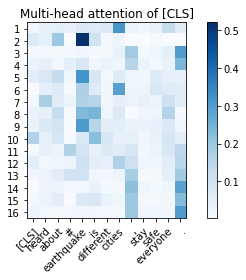

In [84]:
#visualize!
weights = np.array(weights)[:,0:len(input_tokens)-1] # dont need [SEP] token

fig, ax = plt.subplots()
im = ax.imshow(weights,cmap=plt.cm.Blues)
# We want to show all ticks...
ax.set_xticks(np.arange(len(input_tokens)-1))
ax.set_yticks(np.arange(16))
# ... and label them with the respective list entries
ax.set_xticklabels(input_tokens)
ax.set_yticklabels([i for i in range(1,17)])
plt.colorbar(im)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Multi-head attention of [CLS]")
fig.tight_layout()
plt.show()

references: https://arxiv.org/pdf/1810.04805.pdf, https://web.stanford.edu/class/cs224n/reports/custom/15785631.pdf, https://github.com/sebsk/CS224N-Project, UBC Computational Linguistings - Trends in NLP course

## BiLSTM Classfication Comparison

In [39]:
# set the seed
manual_seed = 123
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

batch_size = 32
# We'll take training samples in random order in each epoch. 
# USE SAME PREPROCESS/DATA PREPARE AS FOR BERT
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, 
                              sampler = RandomSampler(train_data), # Select batches randomly
                              batch_size=batch_size)

# We'll just read validation set sequentially.
validation_data = TensorDataset(validation_inputs,  validation_labels)
validation_dataloader = DataLoader(validation_data, 
                                   sampler = SequentialSampler(validation_data), # Pull out batches sequentially.
                                   batch_size=batch_size)

class LSTMmodel(nn.Module):
  
  def __init__(self, embedding_size, vocab_size, output_size, hidden_size, num_layers):
    # In the constructor we define the layers for our model (same as our previous RNN)
    super(LSTMmodel, self).__init__()
    # word embedding lookup table
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
    self.embedding.weight.data.normal_(0.0,0.05) # mean=0.0, mu=0.05

    
    # core LSTM module
    #UPDATE DROPOUT HERE

    #baseline:
    #self.lstm_rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers) # input_size, hidden_size, num_layers

    #with droptout:
    self.lstm_rnn = nn.LSTM(input_size=embedding_size, dropout=.3, hidden_size=hidden_size, num_layers=num_layers) # input_size, hidden_size, num_layers

    #BiLSTM tangent: For the HW you might also try a bidirectional LSTM architecture, this is good for certain tasks such as
    #Named entity recognition. Just add bidirectional=true to your LSTM parameters list. NOTE THIS DOUBLES THE OUTPUT DIMENSION!
    #self.lstm_rnn = nn.LSTM(input_size=embedding_size, bidirectional=True, dropout=.7, hidden_size=hidden_size, num_layers=num_layers) # input_size, hidden_size, num_layers

    
    self.activation_fn = nn.Sigmoid()
    self.linear_layer = nn.Linear(hidden_size, output_size) 

    #For BiLSTM you end up doubling the output from the LSTM (concatenating the two directions together)
    #You'll need to double the input dimension into the linear layer to compensate!
    #self.linear_layer = nn.Linear(hidden_size*2, output_size) 



    self.softmax_layer = nn.LogSoftmax(dim=0)
  
  def forward(self, x):
    # In the forward function we define the forward propagation logic
    out = self.embedding(x.permute(1,0))
    out, (h_state, c_state) = self.lstm_rnn(out) # h_0 initialized to zeros by default
    # classify based on the hidden representation at the last token
    out = out[-1] # unsqueeze converts 1D input (D dimension) into 2D input (1xD) 
    out = self.linear_layer(out)
    out = self.softmax_layer(out) # accepts 2D or more dimensional inputs
    return out

EMBEDDING_SIZE = 300 
VOCAB_SIZE = len(tokenizer)
NUM_CLASSES = 2
HIDDEN_SIZE = 500
NUM_LAYERS = 2
model = LSTMmodel(EMBEDDING_SIZE, VOCAB_SIZE, NUM_CLASSES, HIDDEN_SIZE, NUM_LAYERS)
model = model
print(model)

LEARNING_RATE = 0.01
criterion = nn.NLLLoss()

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def train(loader):
    total_loss = 0.0
    # iterate throught the data loader
    num_sample = 0
    for batch in loader:
        # load the current batch
        batch_input = batch[0] #input_ids, input_mask, labels 
        batch_output = batch[-1]
        
        # batch_input = batch_input.to(device)
        # batch_output = batch_output.to(device)
        # forward propagation
        # pass the data through the model
        model_outputs = model(batch_input)
        # compute the lossval_iter
        
        cur_loss = criterion(model_outputs, batch_output)
        
        #l1_pen = torch.tensor(0.)
        #lambda_1 = 0.00001
        #for name, param in model.named_parameters():
        #    if 'weight' in name:
        #        l1_pen += torch.norm(param, p=1)
        
        total_loss += cur_loss.item()# + len(batch)*lambda_1*l1_pen

        # backward propagation (compute the gradients and update the model)
        # clear the buffer
        optimizer.zero_grad()
        # compute the gradients
        cur_loss.backward()
        # update the weights
        optimizer.step()

        # free GPU memory
        if device == 'cuda':
            torch.cuda.empty_cache()

        num_sample += batch_output.shape[0]
    return total_loss/num_sample

# evaluation logic based on classification accuracy
def evaluate(loader):
    all_pred=[]
    all_label = []
    with torch.no_grad(): # impacts the autograd engine and deactivate it. reduces memory usage and speeds up computation
        for batch in loader:
             # load the current batch
            batch_input = batch[0]
            batch_output = batch[-1]
            # batch_input = batch_input.to(device)
            # forward propagation
            # pass the data through the model
            model_outputs = model(batch_input)
            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(batch_output)
            
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return accuracy,f1score


#Play around with the optimizer, L2 regularization, and momentum here.
#optimizer = torch.optim.RMSprop(model.parameters(),lr=LEARNING_RATE, alpha=0.99)
#optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, betas=(0.9,0.99))
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=.00001)



cuda
LSTMmodel(
  (embedding): Embedding(30522, 300)
  (lstm_rnn): LSTM(300, 500, num_layers=2, dropout=0.3)
  (activation_fn): Sigmoid()
  (linear_layer): Linear(in_features=500, out_features=2, bias=True)
  (softmax_layer): LogSoftmax()
)


Really Bad Results! Too Noisy Without Subword vocab?

In [40]:
# start the training
for epoch in range(30):
    # train the model for one pass over the data
    train_loss = train(iter(train_dataloader))  
    # compute the training accuracy
    train_acc,f1t = evaluate(iter(train_dataloader))
    # compute the validation accuracy
    val_acc,f1v = evaluate(iter(validation_dataloader))
    
    # print the loss for every epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch+1, 30, train_loss, train_acc, val_acc))

Epoch [1/30], Loss: 0.1084, Training Accuracy: 0.5136, Validation Accuracy: 0.4972
Epoch [2/30], Loss: 0.1084, Training Accuracy: 0.4922, Validation Accuracy: 0.5154
Epoch [3/30], Loss: 0.1084, Training Accuracy: 0.5083, Validation Accuracy: 0.5083
Epoch [4/30], Loss: 0.1084, Training Accuracy: 0.5021, Validation Accuracy: 0.4917
Epoch [5/30], Loss: 0.1084, Training Accuracy: 0.4951, Validation Accuracy: 0.5114
Epoch [6/30], Loss: 0.1084, Training Accuracy: 0.5073, Validation Accuracy: 0.4854
Epoch [7/30], Loss: 0.1084, Training Accuracy: 0.5125, Validation Accuracy: 0.4641
Epoch [8/30], Loss: 0.1084, Training Accuracy: 0.4984, Validation Accuracy: 0.4854
Epoch [9/30], Loss: 0.1084, Training Accuracy: 0.5105, Validation Accuracy: 0.5043
Epoch [10/30], Loss: 0.1084, Training Accuracy: 0.5138, Validation Accuracy: 0.5067


KeyboardInterrupt: ignored